### The decision tree with Scikit learn

In [1]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
import numpy as np
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def convert_from_scikit_learn_to_dic_ite(node_index,is_leaves, children_left,children_right,feature,threshold,value,labels,C):
        
        a = is_leaves[0]
        b = feature[0]
        c = threshold[0]
        if (a):
            d = value[0]  #datapoints of each class in the node
            d2 = np.squeeze(d/np.sum(d))
            d3 = np.zeros(C)
            d3[labels] = d2
            e = labels[np.argmax(d2)]
            return {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf': True,
            'prediction': e,
            'labels_distribution':d3}
    
        else:
            left = children_left[0]-node_index[0]
            if(left==-1):
                left_tree = None
            else:
                left_tree = convert_from_scikit_learn_to_dic_ite(node_index[left:],is_leaves[left:], children_left[left:],children_right[left:],feature[left:],threshold[left:],value[left:],labels,C)
            right = children_right[0]-node_index[0]
            if(right==-1):
                right_tree = None
            else:
                right_tree = convert_from_scikit_learn_to_dic_ite(node_index[right:],is_leaves[right:], children_left[right:],children_right[right:],feature[right:],threshold[right:],value[right:],labels,C)
            return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': b,
            'threshold'        : c,
            'left'             : left_tree, 
            'right'            : right_tree,
            'labels_distribution': None}


def convert_from_scikit_learn_to_dic(tree,labels,C):
    # C is the size of the whole labels
    # labels are the labels that are used in the this tree

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    node_index = np.array(range(0,n_nodes))
    Val = tree.tree_.value   #datapoints in node

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

    # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    
    return convert_from_scikit_learn_to_dic_ite(node_index,is_leaves, children_left,children_right,feature,threshold,Val,labels,C)

def classify(tree, x):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        return tree['labels_distribution'] 
    else:
        # split on feature.
        val_split_feature = x[tree['splitting_feature']]
        if val_split_feature < tree['threshold']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'],x)

def evaluate_classification_error_tree(tree, X, y):
    if type(y) == np.uint8:# or X.shape[0] < 2:   #if we have only 1 datapoint in X
        P = classify(tree,X)
        prediction = np.argmax(P)
        error = int(prediction != y)
    else:
        # Apply the classify(tree, x) to each row in your data

        P = map(lambda x: classify(tree,x), X)
        P = np.asarray(P)
        prediction = np.argmax(P,axis=1)
        # Once you've made the predictions, calculate the classification error and return it
        mistakes = sum(prediction != y)
        error = mistakes/len(y)
        
    return error

def intermediate_node_num_mistakes(labels_in_node):
    
    # Corner case: If labels_in_node is empty, return 0
    if len(labels_in_node) == 0:
        return 0
    
    C,unique_counts = np.unique(labels_in_node,return_counts=True) #the id of classes and number of each
    
    return (len(labels_in_node) - unique_counts[np.argmax(unique_counts)])

def datapath(tree, x, branch = 1):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        return branch 
    else:
        # split on feature.
        split_feature = tree['splitting_feature']
        split_threshold = tree['threshold']

        if x[split_feature] < split_threshold:
            return datapath(tree['left'], x, 2*branch)
        else:
            return datapath(tree['right'],x, 2*branch+1)

def expansion_reduction_SKL(tree,XT1,yT1,XT2,yT2,C):

    
    #finding the leaf where each target datapoint ends up
    leavesData1 = map(lambda x: datapath(tree,x), XT1)
    leavesData2 = map(lambda x: datapath(tree,x), XT2)
            
    Uleaves1 = np.unique(leavesData1)  #the path to each leaf followed by data1
    Uleaves2 = np.unique(leavesData2)  #the path to each leaf followed by data2
    Uleaves = list(set(Uleaves1) & set(Uleaves2)) #leaves reached by both data1 and data2
            
    #expanding each leaf on the 1st bootstrap replica of target data
    for i in Uleaves:
        
        ind_data1 = leavesData1==i #indices of datapoints for each leaf
        ind_data2 = leavesData2==i
        
        if len(ind_data1) < 2:  #do not expand if there is only 1 datapoint
            continue
            
        estimator = DecisionTreeClassifier(max_features='sqrt') #use sqrt the number of feat.
        estimator = estimator.fit(XT1[ind_data1,:],yT1[ind_data1]) 
        #print 'Nclasses ExpTree = %s'%np.unique(yT1[ind_data1]) #%estimator.tree_.n_classes
        
        Exp_tree = convert_from_scikit_learn_to_dic(estimator,np.unique(yT1[ind_data1]),C)

        #Is this a good expansion?: computes classification error at each leaf for Data T2
        Err_leavesT2 = intermediate_node_num_mistakes(yT2[ind_data2])/len(yT2[ind_data2])

        #error at the current subtree on Data T2
        Err_subtreeT2 = evaluate_classification_error_tree(Exp_tree, XT2[ind_data2,:], yT2[ind_data2])
        #comparing the error of the subtree with that at the leaf node of the original tree
        if Err_subtreeT2 < Err_leavesT2:
            tree = mergetrees(tree,i,Exp_tree)
            #print 'merging successful!'
            #print 'subtree nodes = %s'%count_nodes(Exp_tree)

        #else:
            #print 'no merging: discard subtree'
    
    return tree



def mergetrees(tree1,leafnr,tree2):
    leafnrbin = bin(leafnr)[3:]  #path is from the 4th element of the binary on: 0 = go left, 1 = go right
    path = ''
    for i in range(len(leafnrbin)):
        if leafnrbin[i] == '0':
            path=path+str("['left']")
        else:
            path=path+str("['right']") 
    # print(path)
    exec ('tree1'+path+"['prediction']"+'=None')
    exec ('tree1'+path+"['is_leaf']"+'=False')
    exec ('tree1'+path+"['left']"+"=tree2['left']")
    exec ('tree1'+path+"['right']"+"=tree2['right']")
    exec ('tree1'+path+"['splitting_feature']"+"=tree2['splitting_feature']")
    exec ('tree1'+path+"['threshold']"+"=tree2['threshold']")
    exec ('del(tree1'+path+"['labels_distribution'])")
    return tree1

###  STRUCT

In [403]:
import numpy as np
import math
from math import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def kl (p,q): # Kullback-libler divegence
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0,(p-q) * np.log10(p / q), 0))
def jsd(p,q): # Symmetric Kullback-libler divegence
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    m = (p+q)/2
    return (kl(p,m)+kl(m,q))/2

def partition(Xtarget,index_of_data,feature,ytarget,C,threshold): # finding the left and right division
    left = index_of_data[Xtarget[index_of_data,feature]<threshold]
    labels_left = ytarget[left]
    right = index_of_data[Xtarget[index_of_data,feature]>=threshold]
    labels_left = ytarget[left]
    QL = np.bincount(labels_left)
    if(len(QL)<C):
        QL = np.append(QL,np.zeros(C-len(QL))) 
    labels_right = ytarget[right]
    QR = np.bincount(labels_right)
    if(len(QR)<C):
        QR = np.append(QR,np.zeros(C-len(QR))) 
    return [QL,left,QR,right]

def dg(Sleft,lenleft,Sright,lenright,QL,QR): # DG function as in the paper, S is the datast with the features
    
    return 1-(lenleft/(lenleft+lenright))*jsd(Sleft,QL)-(lenright/(lenleft+lenright))*jsd(Sright,QR)
    
def threshold_selection(X,y,S,f,QL,QR,C): # finding the best threshold
    Val  = np.array([])
    fvals = np.sort(X[S,f])
    num_data_points = len(fvals)
    if num_data_points > 10:            
        fvals = fvals[range(0,num_data_points,np.floor(num_data_points/10).astype(int))]
    #plt.scatter(fvals)
    #plt.show()
    for i in fvals:
        [Sleft, left, Sright, right] = partition(X,S,f,y,C,i)
        Val = np.append(Val,dg(Sleft,len(left),Sright,len(right),QL,QR)) # this is the divergence measure for each threshold split  
    th = fvals[np.argmax(Val)]
    [ql, left, qr, right] = partition(X,S,f,y,C,th)
    return [th, ql, qr, left, right]
    
def STRUC(Xsource,ysource,Xtarget,ytarget,C):
    # Assumption: ysource has all the labels of the problem 
    estimator = DecisionTreeClassifier(max_features='sqrt',max_leaf_nodes=50,random_state=0)
    estimator = estimator.fit(Xsource, ysource)
    P = list(np.zeros(estimator.tree_.capacity))
    P[0] = range(len(ytarget))
    thresh = np.zeros(estimator.tree_.capacity)
    remain = np.array([0])
    while(len(remain)!=0):
        i = remain[0]
        index_left = estimator.tree_.children_left[i]
        index_right = estimator.tree_.children_right[i]
        if(index_left!=-1):
            QL = estimator.tree_.value[index_left]
            QL = QL/QL.sum()
            QR = estimator.tree_.value[index_right]
            QR = QR/QR.sum()
            f = estimator.tree_.feature[i]
            [th, ql, qr, left, right] = threshold_selection(Xtarget,ytarget,np.array(P[i]),f,QL,QR,C)
            thresh[i] = th
            P[index_left] = left
            P[index_right] = right
            if(len(left)!=0):
                remain = np.append(remain,index_left)
            if(len(right)!=0):
                remain = np.append(remain,index_right)
        remain = remain[1:]
    return [thresh,P]

In [404]:
import numpy as np
import math
from math import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
P = np.array([0])
np.append(P,6)


array([0, 6])

In [405]:
estimator = DecisionTreeClassifier(max_features='sqrt',max_leaf_nodes=10,random_state=0)
estimator = estimator.fit(Xsource, ysource)
[thresh,P] = STRUC(Xsource,ysource,Xtarget,ytarget,10)

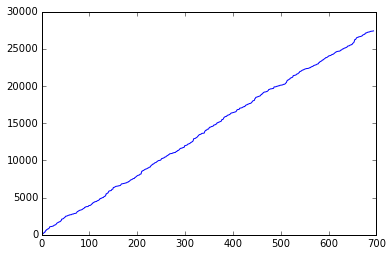

In [407]:
plt.plot(P[16])
plt.show()

In [384]:
thresh

array([ 0.5411765 ,  0.70588237,  0.16470589,  0.        ,  0.0509804 ,
        0.1254902 ,  0.38039219,  0.        ,  0.        ,  0.32156864,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02745098,
        0.        ,  0.        ,  0.        ,  0.        ])

In [229]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
import numpy as np
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=False)
Xtrain = mnist.train.images
Xtest = mnist.test.images
ytrain = mnist.train.labels
ytest = mnist.test.labels
Xsource, Xtarget, ysource, ytarget = train_test_split(Xtrain, ytrain, test_size=0.5)
print Xtrain.shape
print Xtest.shape
print Xsource.shape
print Xtarget.shape
XT1,XT2,yT1,yT2 = train_test_split(Xtarget,ytarget,test_size=0.5)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)
(27500, 784)
(27500, 784)


In [42]:
i = 1
print estimator.tree_.children_left[i]
print estimator.tree_.children_right[i]
QL = estimator.tree_.value[i]
print QL/QL.sum()
estimator.tree_.feature[i]

-1
-1
[[ 0.24585876  0.29195728  0.07922842  0.06233653  0.01721883  0.12271142
   0.05939407  0.03018745  0.07901046  0.01209677]]


-2

In [48]:
P = 1 #[[1],[1,2]]
#P.append([1,2,3])
P!=1

False